In [6]:
import os
import glob

import tables as tb
import numpy  as np
import pandas as pd

from collections import defaultdict
from scipy import interpolate

from gres.database import load_db as db

In [7]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook
%matplotlib inline
### Useful parameters for plots
mpl.rcParams["figure.figsize"]          = 12,10
mpl.rcParams["font.size"]               = 24
mpl.rcParams["figure.max_open_warning"] = 100
mpl.rcParams["font.size"]               = 24
mpl.rcParams["font.weight"]             ='normal'
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w';

In [8]:
#p_mesh = np.array([2.72, 3.71, 4.78, 5.78, 6.78, 7.77, 8.77])[-3:]
p_grid = np.array([9.74, 8.62, 7.63, 6.58, 5.5, 4.5, 3.55, 2.61, 1.51])[::-1][:-1]

source = '55Fe'



dst_path = '/home/ander/Work/GaP/real_data/55Fe/Paper1/EL_yield_dst.h5'

fAlpha = False
dst_alpha_path = '/home/ander/Work/GaP/real_data/241Am/LCE_Study/LCE_and_drift_EL.h5'

data_pmt = db.DataPMT('gap', 750)

In [9]:
from scipy.interpolate import interp1d

j = np.array([95.91971832068714, 78.17935899533668, 59.52111423867904, 42.32965577879311, 28.766139283759546,19.548724270685476,13.902474439144827,10.82778126001136, 8.058421877614814, 4.778331938507145, 3.4763093863088153,2.2574514611449166,1.4659475130423867,1.0425385077307192,0.6469269791785761,0.4106641977223954,0.24350795748598159,0.16176388885439477,0.12315740410163431,0.10504649807437978,0.09591971832068694,0.10268645422887429,0.10993055512157993,0.13797570810297624,0.17715575417179444,0.28875287417994416,0.3836026325548867,0.5272777843225039,0.6042963902381322,0.7584626699552715])
ep = np.array([5.82444733420026,5.7061118335500645,5.5513654096228855,5.36931079323797,5.1690507152145635,4.968790637191157,4.814044213263978,4.713914174252276,4.5955786736020805,4.3862158647594285,4.258777633289988,4.094928478543562,3.9310793237971393,3.8309492847854343,3.6853055916775026,3.557867360208061,3.4122236671001294,3.3029908972691797,3.1300390117035097,3.020806241872561,2.966189856957087,2.8023407022106626,2.638491547464238,2.501950585175552,2.347204161248374,2.0559167750325096,1.88296488946684,1.691807542262679,1.5825747724317294,1.364109232769831])

reso_j_interp = interp1d(ep, j, fill_value='extrapolate')

In [12]:
#Params

wi         = 26.27
dist       = 1.02
fano       = 0.23
ene_source = 5.9e3
wi_kev     = wi/1e3

n_ie       = ene_source/wi

el_yield = lambda x : 81 * x - 47

Max g2 at 1.51 bar = 311.1500090009744 +- 25.643904776716074
Max g2 at 2.61 bar = 316.7154018640927 +- 26.094300787618995
Max g2 at 3.55 bar = 507.9821874599096 +- 41.851931690916395
Max g2 at 4.5 bar = 592.2893108767479 +- 48.801703394165585
Max g2 at 5.5 bar = 528.6060469293209 +- 43.55170330240723
Max g2 at 6.58 bar = 483.6722961712531 +- 39.85798993215314
Max g2 at 7.63 bar = 645.9397408894847 +- 53.217181004781004
Max g2 at 8.62 bar = 730.7221299529921 +- 60.20673267686729


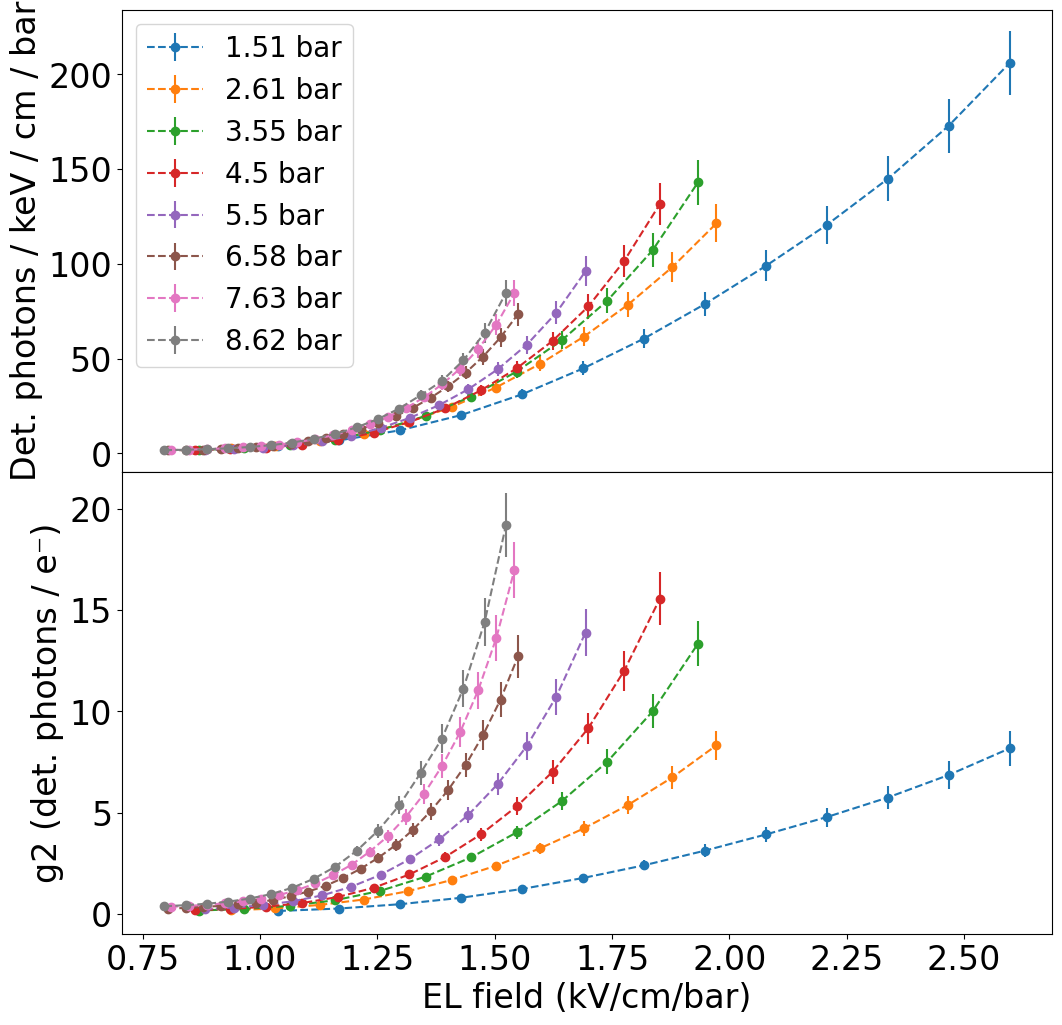

In [46]:
axes=[]
#plt.figure(figsize=(12, 12))
#axes.append(plt.gca())
fig, axes = plt.subplots(2, 1, figsize=(12,12), sharex=True)
fig.subplots_adjust(hspace=0)

interpolators_g = []
min_field       = []
elyield = lambda x : (81*x - 47)*1e3/wi

n_phot_lim = [1e8, -1e8]

data_pmt1 = db.DataPMT('gap', 733)
data_pmt2 = db.DataPMT('gap', 1099)

for pg in p_grid[:]:
    
    dst_g = pd.read_hdf(dst_path, f'{source}_{pg:.2f}bar_Photoetched')
    dst_g = dst_g.sort_values(by='el_volt').reset_index(drop=True)


    ### Photons / keV and / e-
    xdata = dst_g.el_volt/dst_g.pressure/dist 
    ydata = dst_g.photons_kev/dst_g.pressure
    #ydata = ydata/ydata[0]
    yerr  = np.sqrt((np.abs(1 - data_pmt1.adc_to_pes/data_pmt2.adc_to_pes).mean() * ydata)**2 + (dst_g.photons_kev_e/dst_g.pressure)**2)
    
    interpolators_g.append(interp1d(xdata, ydata))#, fill_value='extrapolate'))
    min_field.append(xdata.min())
    yerr_rel = yerr/ydata
    print(f'Max g2 at {pg} bar = {dst_g.photons_kev.max()} +- {(yerr*dst_g.pressure)[dst_g.photons_kev.argmax()]}')
    axes[0].errorbar(xdata,
                     ydata, 
                     yerr=yerr,
                     label=f'{pg} bar', marker='o',ls='--')
    ydata = dst_g.photons_kev * wi_kev
    yerr  = np.sqrt((np.abs(1 - data_pmt1.adc_to_pes/data_pmt2.adc_to_pes).mean() * ydata)**2 + (dst_g.photons_kev_e/dst_g.pressure)**2) 
    
    axes[1].errorbar(xdata,
                     ydata, 
                     yerr=yerr,
                     label=f'{pg} bar', marker='o',ls='--')
                     #label=f'', marker='o',ls='--')

lc = 0.01
#xdata = np.linspace(0.6, 1.5, 101)
#axes[0].plot(xdata, elyield(xdata)*lc, label=f'Coimbra (LC = {lc*100}%)', ls='-')
#for ax in axes[:3]:
    #ax.set_xlabel('EL field (kV/cm/bar)')
axes[0].legend(fontsize=20)
axes[1].set_xlabel('EL field (kV/cm/bar)')

axes[1].set_ylabel('g2 (det. photons / e⁻)')
#axt    .set_ylabel('Det. photons / e⁻ / bar')
#axes[1].set_ylabel('FWHM Resolution (%)')
axes[0].set_ylabel('Det. photons / keV / cm / bar')
#axes[0].set_yscale('log')
#axes[0].set_ylim(1, 3)
fig.savefig(f'/home/ander/Documents/ESS/GanESS/GaP/DetectorPaper/g2_yield_all_pres.pdf', dpi=300)


In [54]:
min_field

[1.0388261264770795,
 0.9390729471865376,
 0.8699254349627186,
 0.8605664488017438,
 0.8823529411764713,
 0.8045771500089398,
 0.8094981111710722,
 0.796142122742368]

Text(0, 0.5, 'Det. photons/keV/cm/bar')

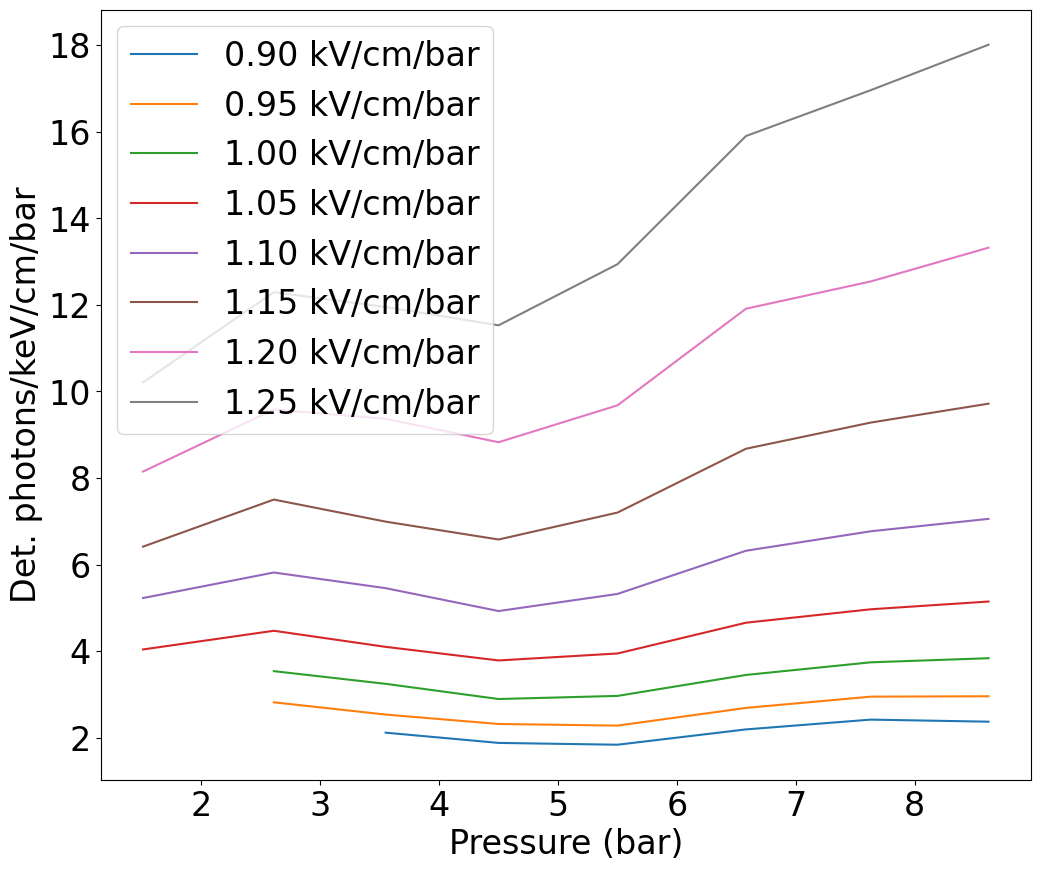

In [56]:
el_plots = np.arange(0.9, 1.3, 0.05)


for el_plot in el_plots:
    xplot = []
    yplot = []
    for i,p in enumerate(p_grid):
        if min_field[i]<el_plot:
            xplot.append(p)
            yplot.append(interpolators_g[i](el_plot))
    
    plt.plot(xplot, yplot, label=f'{el_plot:.2f} kV/cm/bar')
plt.legend()
plt.xlabel('Pressure (bar)')
plt.ylabel('Det. photons/keV/cm/bar')

### Write to file for Leire

In [52]:
ps = np.array([9.74, 8.62, 7.63, 6.58, 5.5, 4.5, 3.55, 2.61, 1.51])[::-1][:]


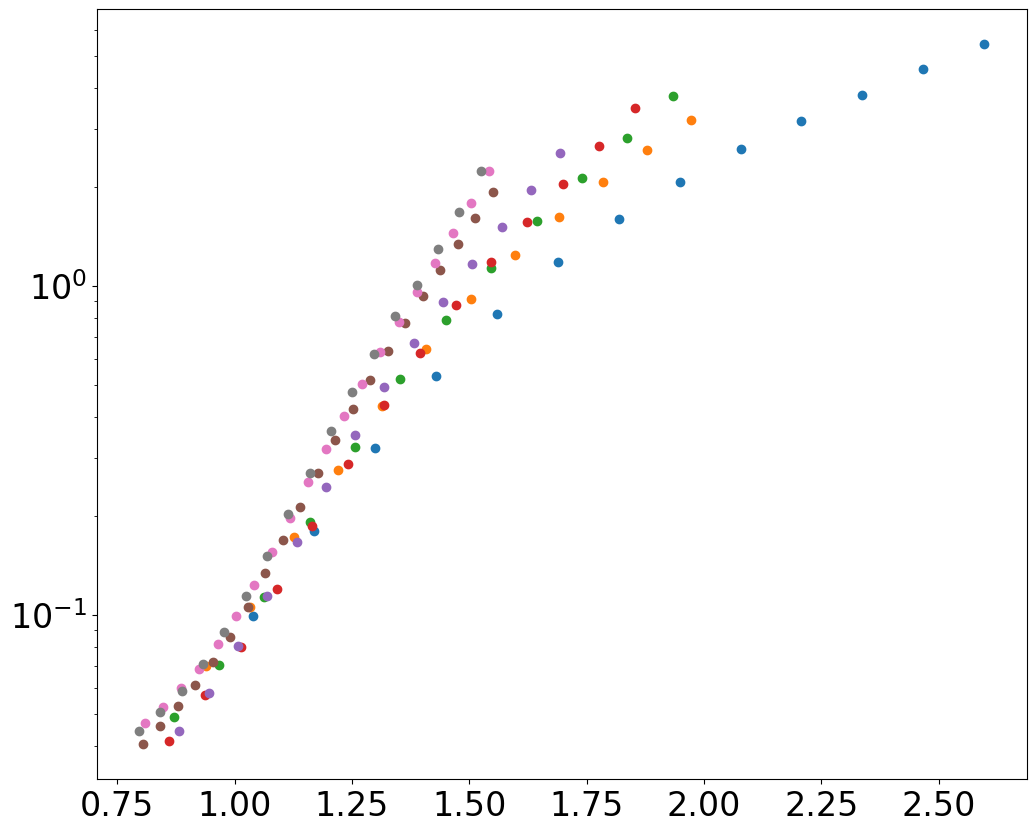

In [55]:
ps = [1.51, 8.62][:]
ps = np.array([9.74, 8.62, 7.63, 6.58, 5.5, 4.5, 3.55, 2.61, 1.51])[::-1][:-1]

for pg in ps:
    dst_g = pd.read_hdf(dst_path, f'{source}_{pg:.2f}bar_Photoetched')
    

    ### Photons / keV and / e-
    xdata   = dst_g.el_volt/dst_g.pressure/dist
    ydata   = dst_g.photons_kev/dst_g.pressure/(1000/wi)
    ydata_e = dst_g.photons_kev_e/dst_g.pressure/(1000/wi)
    plt.scatter(xdata, ydata)
    np.savez(f'/home/ander/Documents/Yield_{pg:.2f}bar.npz',ep=xdata,lyield=ydata,lyield_e=ydata_e)
    
plt.yscale('log')

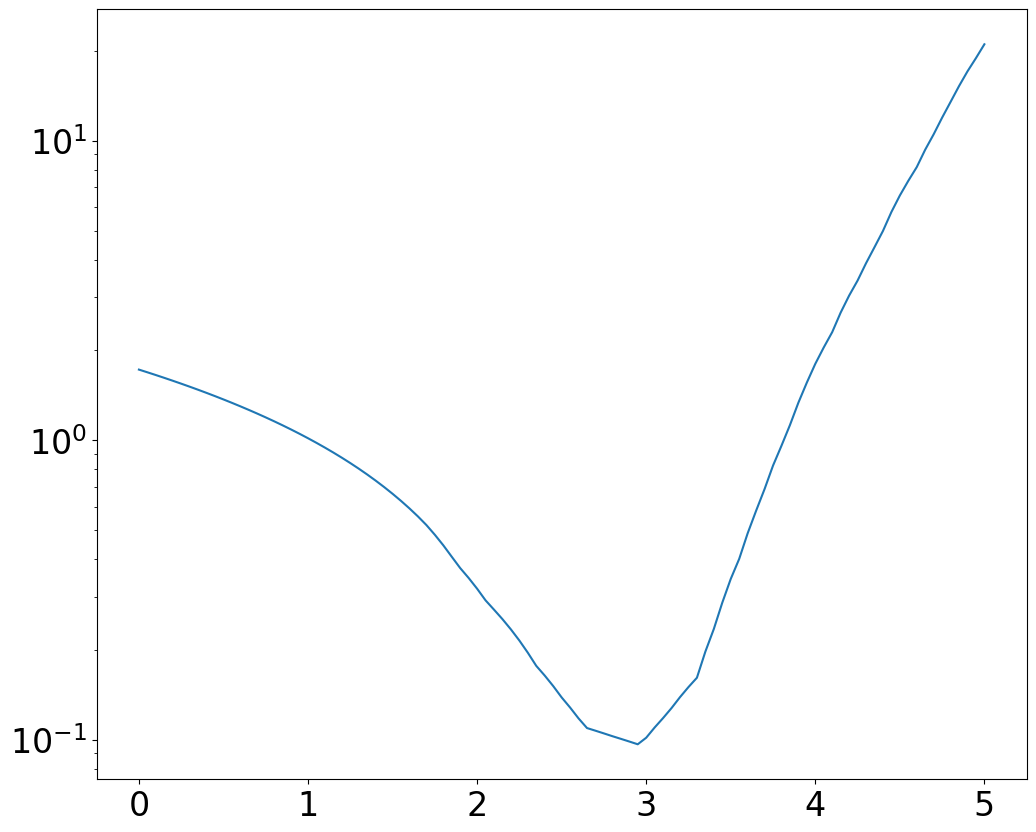

In [143]:
test= np .linspace(0, 5, 101)
plt.plot(test, reso_j_interp(test))
plt.yscale('log')

In [33]:
wire_r    = 50/2
wire_dist = 500
transparency_m = ((wire_dist-wire_r*2)/wire_dist)**2


hex_r      = 1.467
hex_thick  = 150/2/1000 #mum to mm
hex_a      = hex_r * np.sqrt(3)/2
hex_area   = 2.598 * hex_r**2

hex_ring_a = hex_a+hex_thick
hex_ring_r = 2 * hex_ring_a / np.sqrt(3)
hex_ring_area = 2.598 * hex_ring_r**2
transparency_g = hex_area/hex_ring_area

print(f'Transparency of wire mesh: {transparency_m}')
print(f'Transparency of photoetched grid: {transparency_g}')

Transparency of wire mesh: 0.81
Transparency of photoetched grid: 0.891621192133069


In [ ]:
The gate is a thin wire mesh of 50 μm
diameter wires with a 500 μm spacing that has been cryo-
fitted to two concentrical rings acting as a holder. The
anode is a 75 μm thick photoetched hexagonal grid at-
tached to a holder ring with kapton tape in the edges. Its
hexagons have a 1.467 mm side and their contour is 150
μm wide.